# Bayesian Linear Regression

This is to reproduce chapter 3 of the book [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) by Christopher M. Bishop.



In [18]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np 
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt 

from basic.basis import Polynomial
from basic.basis import Gaussian
from basic.linear import BayesianLinearRegression

np.random.seed(111)

## Likilyhood Function

Suppose we are given a dataset $\mathcal{D}=\left\{({\bf x}_n, y_n)\vert {\bf x}_n \in \mathbb{R}^M, y_n\in\mathbb{R} \right\}_{n=1}^N$. Where each element $y_n$ is modelled as


$$
    y_n\vert {\bf x}_n \sim \mathcal{N}({\bf w}^T{\bf x}, \sigma^2)
$$


## Parameter Distribution


Furthermore, we we assign $\bf w$ a *prior* distribution of the form ${\bf w}\sim\mathcal{N}(\boldsymbol\mu_0, \boldsymbol\Sigma_0)$. Our goal is to find the *posterior* distribution ${\bf w}\vert \mathcal{D}$, i.e.,


$$
\begin{aligned}
p({\bf w}\vert \mathcal{D}) &\propto p({\bf w})p(\mathcal D\vert {\bf w})\\
&= \mathcal{N}({\bf w}\vert \boldsymbol\mu_0, \boldsymbol\Sigma_0) \mathcal{N}({\bf y} \vert {\bf X}{\bf w}, \sigma^2{\bf I})
\end{aligned}
$$

To find the posterior conjugate (a closed-form solution), note that

$$
    {\bf z}^T{\bf A}{\bf z} - 2{\bf z}^T{\bf b} + c = ({\bf z} - {\bf A}^{-1}{\bf b})^T{\bf A}({\bf z} - {\bf A}^{-1}{\bf b}) - {\bf b}^T{\bf A}^{-1}{\bf b} + c
$$

Then,
$$
\begin{align}
    p({\bf w}\vert \mathcal{D}) &\propto \exp\left(-\frac{1}{2} ({\bf w} - \boldsymbol\mu_0)^T\Sigma_0^{-1}({\bf w} - \boldsymbol\mu_0) -\frac{1}{2\sigma^2} ({\bf y} - {\bf X w})^T({\bf y} - {\bf X w}) \right)\\
    &= \exp\left(-\frac{1}{2}\left( ({\bf w} - \boldsymbol\mu_0)^T\Sigma_0^{-1}({\bf w} - \boldsymbol\mu_0) +\frac{1}{\sigma^2} ({\bf y} - {\bf X w})^T({\bf y} - {\bf X w})\right) \right)\\
    &\propto \exp\left(-\frac{1}{2}\left[{\bf w}^T \left(\boldsymbol\Sigma_0^{-1} + \frac{1}{\sigma^2}{\bf X}^T{\bf X}\right) - 2{\bf w}^T \left(\boldsymbol\Sigma_0^{-1}\boldsymbol\mu_0 + \frac{1}{\sigma^2}{\bf X}^T{\bf y}\right) \right]\right)
\end{align}
$$

This last expression reduces to

$$
    p({\bf w}\vert \mathcal{D}) \propto \exp\left(-\frac{1}{2}({\bf w} - {\bf m}_N)^T {\bf S}_N^{-1} ({\bf w} - {\bf m}_N)\right)
$$

Where
* ${\bf S}_N^{-1} = \boldsymbol\Sigma_0^{-1} + \frac{1}{\sigma^2}{\bf X}^T{\bf X}$
* ${\bf m}_N = {\bf S}_N \left(\boldsymbol\Sigma_0^{-1}\boldsymbol\mu_0 + \frac{1}{\sigma^2}{\bf X}^T{\bf y}\right)$

Using a bayesian perspective, there does not exist *a* vector of weights $\bf w$; rather, $\bf w$ is a random variable that we can sample from.

The following is to reproduce Figure 3.7 of the book.

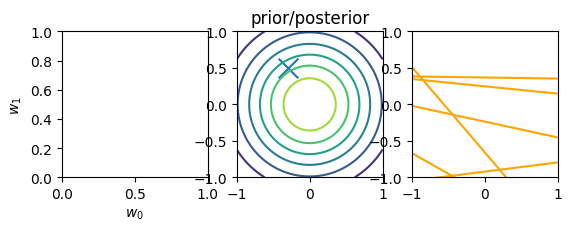

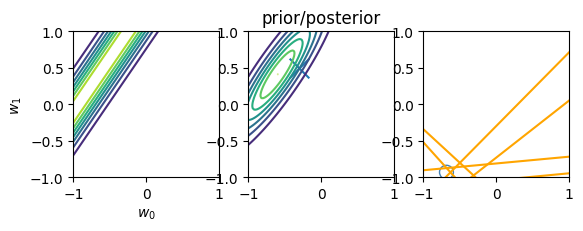

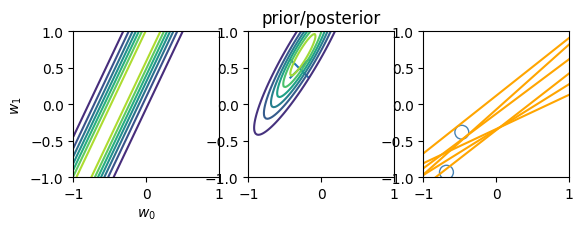

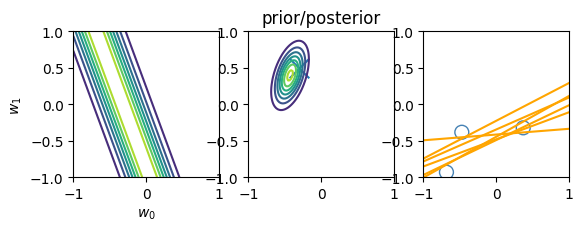

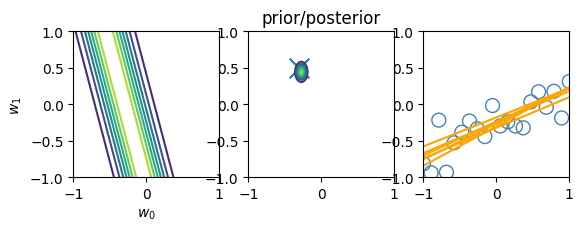

In [19]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def linear(x, a0, a1):
    return a0 + a1 * x

# data generation
a0 = -0.3
a1 = 0.5
std = 0.2 
beta = 1/std**2
x_train, y_train = create_toy_data(lambda x: linear(x, a0, a1), 20, std, [-1, 1])
x = np.linspace(-1, 1, 100)

# add polynomial features
basis = Polynomial()
X_train = basis.transform(x_train, degree=1)
X = basis.transform(x, degree=1)

# bayesian linear regression
bayesian = BayesianLinearRegression()

# initialize prior distribution of w
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100))
w = np.array([w0, w1]).transpose(1, 2, 0)

alpha = 2.0 # precision of noise
w_mean, w_var = bayesian.init_w_prior(X_train, alpha)

# plot
for begin, end in [[0,0], [0, 1], [1, 2], [2, 3], [3, 20]]:

    plt.subplot(1,3,1)
    if end > 0:
        # calculate maximum likelihood pdf of current incomming point
        y_obs = y_train[end-1]
        x_obs = X_train[end-1]
        like_mean = w.reshape(-1,2) @ x_obs.T
        like_std = std
        likelihood = norm.pdf(y_obs, loc=like_mean, scale=like_std)
        likelihood = likelihood.reshape(100,100)
        plt.contour(w0, w1, likelihood)
        w_mean, w_var = bayesian.fit(beta, w_mean, w_var, X_train[begin: end], y_train[begin: end])
    plt.gca().set_aspect('equal')
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")
         
    plt.subplot(1, 3, 2)
    plt.scatter(-0.3, 0.5, s=200, marker="x")
    plt.contour(w0, w1, multivariate_normal.pdf(w, mean=w_mean, cov=w_var))
    plt.gca().set_aspect('equal')
    plt.title("prior/posterior")

    plt.subplot(1, 3, 3)
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=1)
    # sample 6 parameter pairs for plotting
    w_samples = np.random.multivariate_normal(w_mean, w_var, size=6)
    y_samples = X @ w_samples.T
    plt.plot(x, y_samples, c="orange")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    

## Posterior Predictive Distribution

Most times, we are not interested in the values of parameters $\bf{w}$, but instead the prediction of a new data point $\bf x$. To do so, we need to integrate out the parameters $\bf w$ from the posterior distribution $p({\bf w}\vert \mathcal{D})$.

Before taking the sample, the uncertainty in $\bf w$ is represented by the prior distribution $p(\bf w)$.
So for new data point $\bf x$, averaging over $p(\bf w)$ gives the `prior predictive distribution`:

$$
p(y|\bf{x}) = \int_{\bf{w}} p(y| \bf{x}, \bf{w}) d\bf{w} = \int_{\bf{w}} p(y|\bf{x}, \bf{w})p(\bf{w})d\bf{w} 
$$

After taking the sample, the uncertainty in $\bf w$ is represented by the posterior distribution $p({\bf w}\vert \mathcal{D})$. 
So the `posterior prediction distribution` is:

\begin{align}
p(y|\bf{x}, \mathcal{D}) &= \int_{\bf{w}} p(\textit{y}, \bf{w}|\bf{x}, \mathcal{D}) d\bf{w} \\
                        &= \int_{\bf{w}} p(\textit{y}|\bf{x}, \bf{w}, \mathcal{D})p(\bf{w}|\mathcal{D})d\bf{w}\\
                        &= \int_{\bf{w}} p(\textit{y}|\bf{x}, \bf{w})p(\bf{w}|\mathcal{D})d\bf{w} \leftarrow \text{new data is independent of samples}\\
\end{align}

The convolution of two Gaussian distributions is another Gaussian distribution. So the posterior predictive distribution is also a Gaussian distribution:

$$
p(y|\bf{x}, \mathcal{D}) = \mathcal{N}(y|\bf{x}^T\bf{m}_N, \sigma^2 + \bf{x}^T\bf{S}_N\bf{x})
$$

Where $\bf{m}_N$ and $\bf{S}_N$ are the posterior mean and covariance respectively.

The following code is to reproduce Figure 3.8 - Figure 3.9 of the book.

/tmp/ipykernel_206127/4109270509.py:47: RuntimeWarning: covariance is not positive-semidefinite.
  w_samples = np.random.multivariate_normal(w_mean, w_var, size=6)


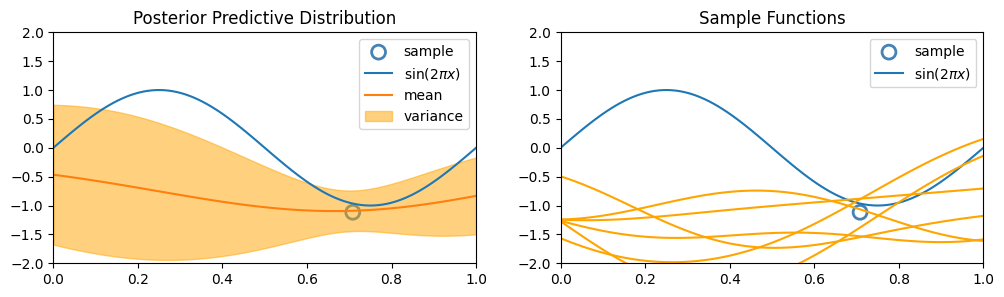

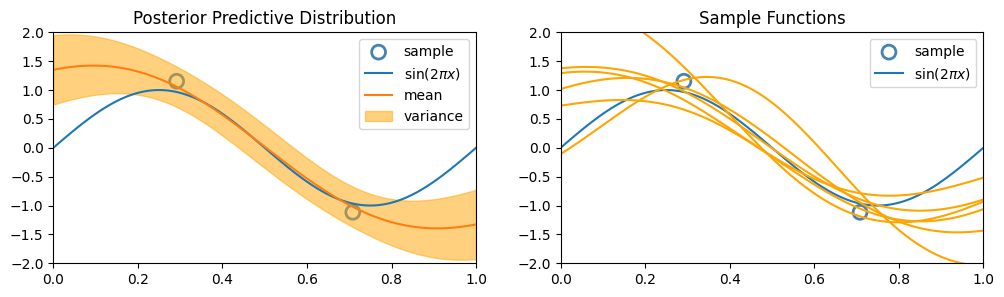

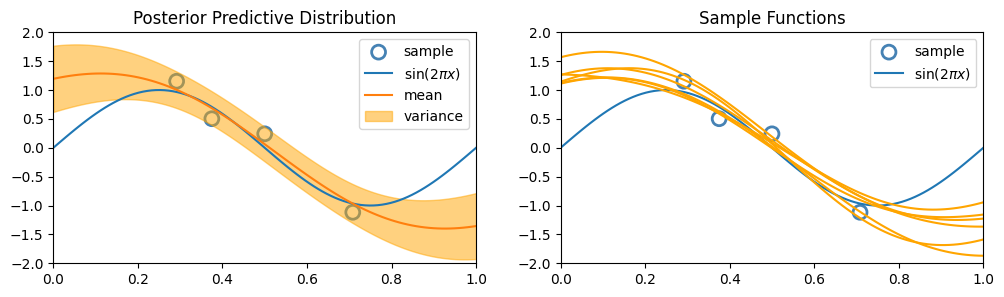

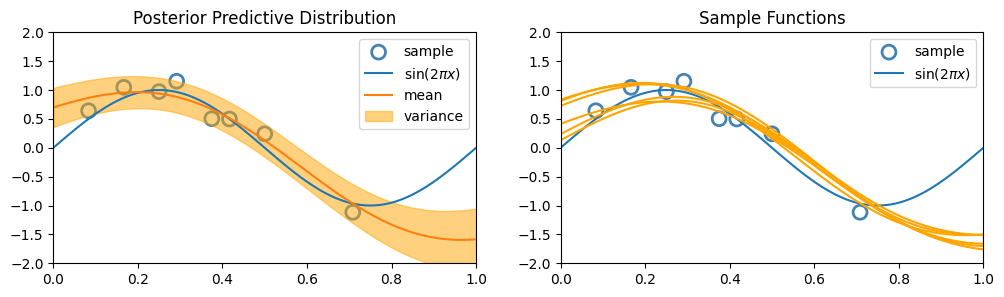

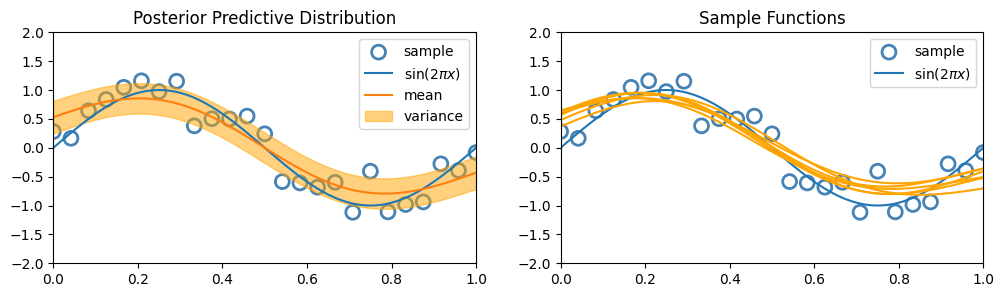

In [22]:
def sinusoidal(x):
    return np.sin(2 * np.pi * x)

samples = 25
std = 0.25
beta = 1/std**2

x_train, y_train = create_toy_data(sinusoidal, samples, std)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

feature = Gaussian()
feature_mean, feature_var = np.linspace(0, 1, 9), 0.1
X_train = feature.transform(x_train, feature_mean, feature_var)
X_test = feature.transform(x_test, feature_mean, feature_var)

model = BayesianLinearRegression()

# initialize prior distribution of w
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100))
w = np.array([w0, w1]).transpose(1, 2, 0)

alpha = 2.0 # precision of noise
w_mean, w_var = model.init_w_prior(X_train, alpha)

for begin, end in [[0, 1], [1, 2], [2, 4], [4, 8], [8, 25]]:
    w_mean, w_var = model.fit(beta, w_mean, w_var, X_train[begin: end], y_train[begin: end])
    y, y_std = model.predict(beta, w_mean, w_var, X_test)
    
    plt.figure(figsize=(12, 3))
    plt.subplot(1,2,1)
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=2, label="sample")
    plt.plot(x_test, y_test, label='$\sin(2\pi x)$')
    plt.plot(x_test, y, label="mean")
    plt.fill_between(x_test, (y - y_std).reshape(-1), (y + y_std).reshape(-1), color="orange", alpha=0.5, label='variance')
    plt.xlim(0, 1)
    plt.ylim(-2, 2)
    plt.legend()
    plt.title('Posterior Predictive Distribution')
    
    plt.subplot(1,2,2)
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=2, label="sample")
    plt.plot(x_test, y_test, label='$\sin(2\pi x)$')
    # sample 6 parameter pairs for plotting
    w_samples = np.random.multivariate_normal(w_mean, w_var, size=6)
    y_samples = X_test @ w_samples.T
    plt.plot(x_test, y_samples, c="orange")
    plt.xlim(0, 1)
    plt.ylim(-2, 2)
    plt.legend()
    plt.title('Sample Functions')
    plt.show()
